In [1]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from util_kelly import simulate_kelly_strategy, StockMarketData, plot_strategy

In [2]:
def optimized_kelly_strategy(data):
    return simulate_kelly_strategy(data, rebalancing_interval=1, annual_risk_free_rate=0.02,\
     window=350, min_kelly=0, max_kelly=10, kelly_fraction=0.4)

In [3]:
def backtest_kelly_strategy(kelly_strategy, number_repeats=100, investment_horizon=5040):
    DATE_MAX = pd.Timestamp(2022, 2, 14).to_pydatetime() + timedelta(days=-investment_horizon)
    year_range = [1885, DATE_MAX.year]
    month_range = [1, 12]
    day_range = [1, 28]
    PATH_TO_CSV = 'data/spx_day.csv'
    simulation_data = StockMarketData(PATH_TO_CSV, parse_dates=['Date'], infer_datetime_format=True, index_col=0)

    simulation_history = []
    summary_statistics = pd.DataFrame()
    date = [None for _ in range(number_repeats)]
    strategy_cumulative_returns = np.empty((number_repeats))
    standard_cumulative_returns = np.empty((number_repeats))

    for i in range(number_repeats):
        start_year = np.random.randint(year_range[0], year_range[1])
        start_month = np.random.randint(month_range[0], month_range[1])
        start_day = np.random.randint(day_range[0], day_range[1])
        start_date = pd.Timestamp(start_year, start_month, start_day).to_pydatetime()
        end_date = start_date + timedelta(days=investment_horizon)
        # run simulation
        simulation_data.restrict_date(start_date=start_date, end_date=end_date)
        returns = kelly_strategy(simulation_data.get_data())
        # collect simulation history
        tmp_simulation_history = pd.DataFrame()
        tmp_simulation_history[f"date_{i}"] = returns['Date']
        tmp_simulation_history[f"strategy_cum_returns_{i}"] = returns["strategy_cum_returns"]
        tmp_simulation_history[f"cum_returns_{i}"] = returns["cum_returns"]
        simulation_history.append(returns)
        #if i == 0:
        #    simulation_history = tmp_simulation_history
        #else:
        #    simulation_history = pd.concat([simulation_history, tmp_simulation_history], axis=1)
        # collect summary statistics
        date[i] = start_date
        strategy_cumulative_returns[i] = returns["strategy_cum_returns"].iloc[-1]
        standard_cumulative_returns[i] = returns["cum_returns"].iloc[-1]
    
    summary_statistics['date'] = date
    summary_statistics['strategy_cum_returns'] = strategy_cumulative_returns
    summary_statistics['cum_returns'] = standard_cumulative_returns

    return simulation_history, summary_statistics

In [4]:
PATH_TO_CSV = 'data/spx_day.csv'
simulation_data = StockMarketData(PATH_TO_CSV, parse_dates=['Date'], infer_datetime_format=True, index_col=0)
base = simulate_kelly_strategy(simulation_data.get_data(), rebalancing_interval=1, annual_risk_free_rate=0.02,\
     window=350, min_kelly=0, max_kelly=100, kelly_fraction=1.0)

/home/pafrank/anaconda3/envs/trading-sp500/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
history, summary_statistics = backtest_kelly_strategy(optimized_kelly_strategy)

In [6]:
summary_statistics.describe()

,strategy_cum_returns,cum_returns
count,100.000000,100.000000
mean,0.887966,0.732065
std,1.029944,0.556419
min,-0.958344,-0.868692
25%,-0.006228,0.336830
50%,0.729299,0.668765
75%,1.785892,1.174030
max,3.127758,1.963144


<AxesSubplot:>

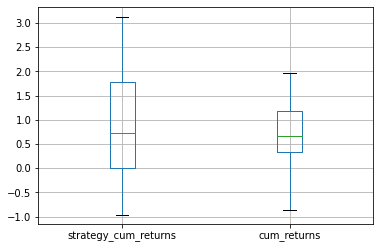

In [7]:
summary_statistics.boxplot(column=['strategy_cum_returns', 'cum_returns'])

In [8]:
history.describe()

AttributeError: 'list' object has no attribute 'describe'

In [10]:
#ax.plot(base['cum_returns'], label='base')
for i in range(100):
    fig, ax = plt.subplots(figsize=(12, 8), sharex=True)
    #color = cm.get_cmap('gist_rainbow')(i)
    for j in range(i):
        ax.plot(history[j]["strategy_cum_returns"], color='grey', linewidth=0.5)
        ax.plot(history[j]["cum_returns"], color='grey', linewidth=0.5)
    ax.plot(history[i]["strategy_cum_returns"], color='red', linewidth=2)
    ax.plot(history[i]["cum_returns"], color='blue', linewidth=2)
    
    plt.tight_layout()
    plt.savefig(f'plots/hist{i:03d}')
    plt.close()

In [15]:
!convert -delay 100 -loop 1 plots/hist*.png simulation_runs.gif

![SegmentLocal](simulation_runs.gif "segment")